## Extracting Deep Cognitive Features from Bridge Inspectors Eye Tracking Data

Previous to this study we collected data from five different PhD engineering students on the task of inspecting a bridge in a virtual environment. The students were given 3 minutes to inspect a bridge inside of a Unity platform that we have developed, and take images of any defects, cracks, or areas of concern that they found on the bridge. During their inspection we collected data of their character's movement as well as eye movement. Below you see an example of the type of data that was obtained at one time step:

```xml
<?xml version="1.0" encoding="utf-8"?>
<Data>
  <GazeData>
    <DisplayDimensions Width="1920" Height="1080" />
    <Timestamp>902049965729</Timestamp>
    <GazeOrigin>
      <CombinedGazeRayScreen Origin="(7656.03600000, 927.89240000, -1049.60500000)" Direction="(-0.95211820, -0.28659020, 0.10647600)" Valid="True" />
    </GazeOrigin>
    <pupil average_pupildiameter="4.157799" />
    <IntersectionPoint X="4420.004" Y="-46.16226" Z="-687.7166" />
    <HitObject Name="RW_Bridge_Vologda_II_track_LOD0">
      <ObjectPosition X="0" Y="0" Z="0" />
    </HitObject>
    <PositionOnDisplayArea X="0.5182106" Y="0.5221348" />
  </GazeData>
  <CameraData>
    <Timestamp>902049965729</Timestamp>
    <CameraOrigin X="7656.323" Y="927.9785" Z="-1049.637" />
    <CameraDirection X="-0.9624248" Y="-0.2623872" Z="0.06994079" />
  </CameraData>
<Data>
```

One can see information such as the time of the data point, the location and viewing direction of the inspector at this time as well as the location where their eye were looking. This data was collected at a rate of 60 fps, therefore for 3 minutes of data we have 5400 data points.

### Goal

Our goal in this experiment is to determine whether we can use machine learning to make insights into the cognitive behavior of the inspectors based on this eye tracking data. For example, a successful insight would be if we can correctly identify whether a person is planning, searching, or deciding at every point in their search. For example, when the person is first planning where on the bridge to look, then the person might be actively looking, once the person finds something interesting such as a crack they will be deciding whether this is something they should take a picture of or not.

In addition to these fine-scaled, granular behavioral patterns, we would also like to see if machine learning methods can identify more "big picture" patterns, such as classifying search styles based on a larger set of data.

We believe that the insights gathered from these methods can be used as tools to make concrete data-driven decisions for designing training procedures for new inspectors, or comparing the efficiency of different inspection patterns.

### Methodology

In order to extract deep features from our data we propose two methods. 

The first method consists of using dimensionality reduction and clustering techniques such as PCA, t-SNE, and k-means on manually extracted feature vectors, such as velocity, acceleration, rate of fixations to saccades, etc. Then investigating these reduced dimensionality arrays to determine which combination of features creates the most meaningful feature space.

The second method involves using similar dimensionality reduction techniques on feature vectors extracted from unsupervised feature extraction techniques such as Deep Autoencoders, Variational Autoencoders, LSTM Autoencoders, etc.

We will then visualize the two methods and extract clusters of points, then we will interpret the clusters to find whether they correspond to certain parts of the inspection process or different search patterns. We can apply both of these methods on a global as well as local level to get different types of clustering.

For example, if we apply the method "locally" meaning that we divide the dataset into 1 second intervals and perform the clustering on these 1 second intervals then we expect the clusters to represent local/short term cognitive behavior such as whether a person is searching or planning.

On the other hand, if we perform the clustering "globally" meaning that we use the entire data record we expect the clusters to represent more global characteristics about the search, such as search strategy, or who the inspector is.

Something to keep in mind is that we want to anonymize the data records as much as possible to avoid clustering based on trivial factors such as the exact locations that inspectors looked at or other features that wouldn't generalize well and wouldn't truly represent an inspector's cognitive behavior.

### Table of Contents (TO-DO)


<ul>
    <li>Loading Data</li>
    <li>Local clustering</li>
        <ul>
            <li>Breaking up the data</li>
            <li>Method 1
                <ul>
                    <li>Extracting manual features</li>
                    <li>Trying different clustering techniques</li>
                    <li>Visualizing clusters</li>
                </ul>
            </li>
            <li>Method 2
                <ul>
                    <li>Training Deep AE, VAE, and LSTM AE</li>
                    <li>Extracting deep features</li>
                    <li>Clustering / dimensionality reduction of deep features</li>
                    <li>Visualizing clusters</li>
                </ul>
            </li>
            <li>Testing generality of clusters</li>
            <li>Findings and conclusions</li>
        </ul>
    <li>Global clustering
        <ul>
            <li>Extracting manual global features</li>
            <li>Extracting deep features (Training extractor model)</li>
            <li>Clustering techniques</li>
            <li>Visualizing clusters</li>
            <li>Testing generality of clusters</li>
            <li>Findings and conclusions</li>
        </ul>
    </li>
</ul>

## Loading Data <a name="loading-data"></a>

In this section we will load the data from the different users' xml files.

The data is located in the test_1 folder. The files are divided into two data records for each user, the first data record is for the task of bridge inspection (with suffix "_truss.xml"). The second data record is for the task of looking for a certain object inside a warehouse (with suffix "_warehouse.xml"). We will use the second data record for testing the generality of our clusters, but not for generating the classifiers themselves.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # Use notebook version for better display
import importlib
import gc
import pickle
import data_loader
importlib.reload(data_loader)
import manual_features
importlib.reload(manual_features)

<module 'manual_features' from 'c:\\Users\\xavie\\Documents\\2025\\02 UIUC SPRING 2025\\02 CEE498 ML\\03 Project\\02 GitHub Docs\\eyeDataViz\\CE497_final_proj\\manual_features.py'>

In [3]:
# Set plot style
sns.set_theme(style="whitegrid", palette="muted", color_codes=True)

# Specify the folder containing the XML data
DATA_FOLDER = "test_1" # Make sure this folder exists relative to the notebook
# Load the data
truss_data, warehouse_data = data_loader.load_all_data(DATA_FOLDER)

# Display some basic info about the loaded data
if truss_data:
    # Example: Display head of the first truss dataset
    first_key = list(truss_data.keys())[0]
    print(f"\nHead of data for '{first_key}':")
    first_key_df = data_loader.data_dict_to_df(truss_data[first_key])
    display(first_key_df.head())
    print(f"\nInfo for '{first_key}':")
    first_key_df.info()
print("\nTruss Data Keys:", list(truss_data.keys()))
print("\nWarehouse Data Keys:", list(warehouse_data.keys()))

Found 8 XML files in test_1


Loading XML files:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded Ishfaq_truss.xml (20 rows) as key 'Ishfaq_truss'
Loaded Ishfaq_warehouse.xml (20 rows) as key 'Ishfaq_warehouse'
Loaded Mohamad_truss.xml (20 rows) as key 'Mohamad_truss'
Loaded Mohamad_warehouse.xml (20 rows) as key 'Mohamad_warehouse'
Loaded Runze_truss.xml (20 rows) as key 'Runze_truss'
Loaded Runze_warehouse.xml (20 rows) as key 'Runze_warehouse'
Loaded Yuxiang_truss.xml (20 rows) as key 'Yuxiang_truss'
Loaded Yuxiang_warehouse.xml (20 rows) as key 'Yuxiang_warehouse'

Loaded 4 truss datasets.
Loaded 4 warehouse datasets.

Head of data for 'Ishfaq_truss':


,Time_sec,X_2d_X,X_2d_Y,PupilDiameter,GazeOrigin_X,GazeOrigin_Y,GazeOrigin_Z,GazeDirection_X,GazeDirection_Y,GazeDirection_Z,GazeIntersect_X,GazeIntersect_Y,GazeIntersect_Z,CameraDirection_X,CameraDirection_Y,CameraDirection_Z,CameraOrigin_X,CameraOrigin_Y,CameraOrigin_Z
0,0.000000,0.518211,0.522135,4.157799,7656.036,927.8924,-1049.605,-0.952118,-0.286590,0.106476,4420.004,-46.16226,-687.7166,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637
1,0.017018,0.515912,0.527296,4.175835,7656.037,927.8907,-1049.606,-0.950918,-0.292255,0.101698,4522.152,-35.27591,-714.4445,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637
2,0.033244,0.491616,0.474780,4.185173,7656.031,927.9082,-1049.621,-0.970788,-0.233966,0.053210,3722.900,-20.00015,-834.0400,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637
3,0.049965,0.488096,0.398515,4.163857,7656.024,927.9337,-1049.622,-0.987827,-0.148152,0.047419,1239.287,-34.43248,-741.5964,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637
4,0.066835,0.499238,0.321722,4.161942,7656.018,927.9594,-1049.615,-0.995547,-0.062378,0.070678,1379.290,534.67910,-604.0040,-0.962425,-0.262387,0.069941,7656.323,927.9785,-1049.637



Info for 'Ishfaq_truss':
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11524 entries, 0 to 11523
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Time_sec           11524 non-null  float64
 1   X_2d_X             11029 non-null  float64
 2   X_2d_Y             11029 non-null  float64
 3   PupilDiameter      11029 non-null  float64
 4   GazeOrigin_X       11524 non-null  float64
 5   GazeOrigin_Y       11524 non-null  float64
 6   GazeOrigin_Z       11524 non-null  float64
 7   GazeDirection_X    11524 non-null  float64
 8   GazeDirection_Y    11524 non-null  float64
 9   GazeDirection_Z    11524 non-null  float64
 10  GazeIntersect_X    10067 non-null  float64
 11  GazeIntersect_Y    10067 non-null  float64
 12  GazeIntersect_Z    10067 non-null  float64
 13  CameraDirection_X  11524 non-null  float64
 14  CameraDirection_Y  11524 non-null  float64
 15  CameraDirection_Z  11524 non-null  float64
 

## Local Clustering
### Calculating manual <a name="manual-features"></a>

c:\Users\xavie\Documents\2025\02 UIUC SPRING 2025\02 CEE498 ML\03 Project\02 GitHub Docs\eyeDataViz\CE497_final_proj\manual_features.py:264: RuntimeWarning: invalid value encountered in divide
  df_filtered["eye_theta"] = np.arccos(np.sum(eye_dir * eye_dir_prev, axis=1)


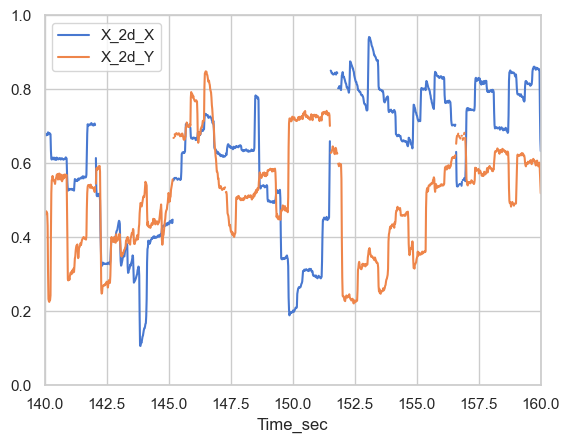

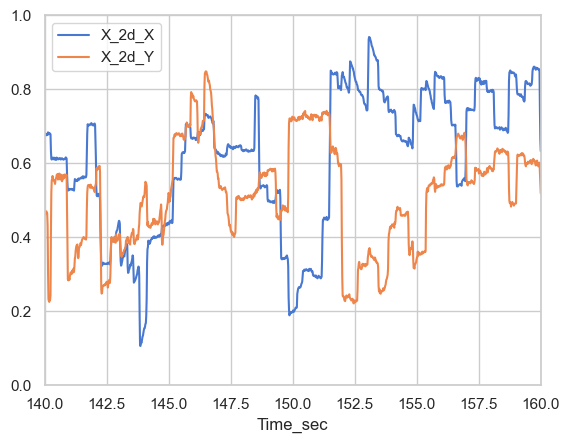

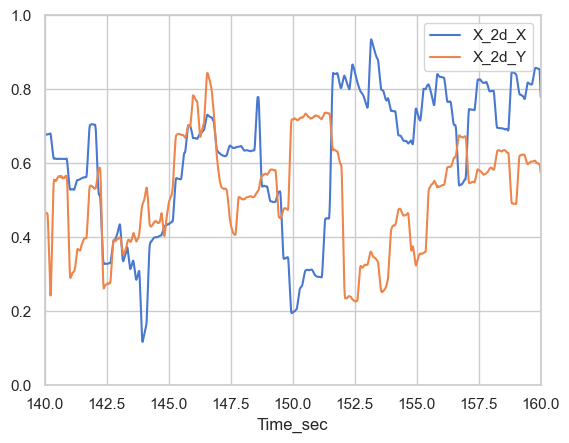

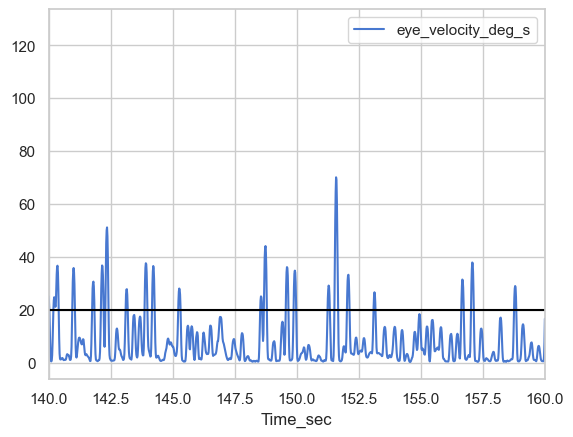

In [4]:
example_df = data_loader.data_dict_to_df(truss_data["Ishfaq_truss"])

# Preliminary data cleaning
example_df = manual_features.index_by_time(example_df)
example_df = manual_features.make_nan_rows(example_df)
example_df = manual_features.identify_gaps(example_df, max_gap_duration_ms=75)
example_df.plot(x="Time_sec", y=["X_2d_X", "X_2d_Y"], xlim=(140,160), ylim=(0,1))

# Filling in gaps by interpolation
example_df = manual_features.fill_gaps(example_df)
example_df.plot(x="Time_sec", y=["X_2d_X", "X_2d_Y"], xlim=(140, 160), ylim=(0,1))

# Reduce noise with low pass filter
example_df = manual_features.noise_filter(example_df, width_ms=100)
example_df.plot(x="Time_sec", y=["X_2d_X", "X_2d_Y"], xlim=(140, 160), ylim=(0,1))

# Calculate velocities and accelerations
example_df = manual_features.calculate_velocity_acceleration_columns(example_df)

# Fixation classification
example_df = manual_features.fixation_classification(example_df, velocity_threshold_deg_s= 20)

ax = example_df.plot(x="Time_sec", y=["eye_velocity_deg_s"], xlim=(140, 160))
ax.hlines([20], 0, 200, "black")


In [222]:
# Process all truss data with the same steps as the example
for key, data in truss_data.items():
    print(f"\nProcessing {key}...")
    df = data_loader.data_dict_to_df(data)
    # Preliminary data cleaning
    df = manual_features.index_by_time(df)
    df = manual_features.make_nan_rows(df)
    df = manual_features.identify_gaps(df, max_gap_duration_ms=75)
    # Fill gaps by interpolation
    df = manual_features.fill_gaps(df)
    # Reduce noise with low pass filter
    df = manual_features.noise_filter(df, width_ms=100)
    # Calculate velocities and accelerations
    df = manual_features.calculate_velocity_acceleration_columns(df)
    # Fixation classification
    df = manual_features.fixation_classification(df, velocity_threshold_deg_s=20)
    # Update the dictionary with processed dataframe
    truss_data[key] = df
print("\nProcessing complete for all truss data.")


Processing Ishfaq_truss...


c:\Users\DANNY\Documents\Projects\CE497_final_proj\manual_features.py:266: RuntimeWarning: invalid value encountered in divide
  df_filtered["eye_theta"] = np.sum(eye_dir * eye_dir_prev, axis=1) / np.linalg.norm(eye_dir, axis=1) / np.linalg.norm(eye_dir_prev, axis=1)



Processing Mohamad_truss...


c:\Users\DANNY\Documents\Projects\CE497_final_proj\manual_features.py:266: RuntimeWarning: invalid value encountered in divide
  df_filtered["eye_theta"] = np.sum(eye_dir * eye_dir_prev, axis=1) / np.linalg.norm(eye_dir, axis=1) / np.linalg.norm(eye_dir_prev, axis=1)



Processing Runze_truss...


c:\Users\DANNY\Documents\Projects\CE497_final_proj\manual_features.py:266: RuntimeWarning: invalid value encountered in divide
  df_filtered["eye_theta"] = np.sum(eye_dir * eye_dir_prev, axis=1) / np.linalg.norm(eye_dir, axis=1) / np.linalg.norm(eye_dir_prev, axis=1)
c:\Users\DANNY\Documents\Projects\CE497_final_proj\manual_features.py:266: RuntimeWarning: invalid value encountered in arccos
  df_filtered["eye_theta"] = np.sum(eye_dir * eye_dir_prev, axis=1) / np.linalg.norm(eye_dir, axis=1) / np.linalg.norm(eye_dir_prev, axis=1)



Processing Yuxiang_truss...


c:\Users\DANNY\Documents\Projects\CE497_final_proj\manual_features.py:266: RuntimeWarning: invalid value encountered in divide
  df_filtered["eye_theta"] = np.sum(eye_dir * eye_dir_prev, axis=1) / np.linalg.norm(eye_dir, axis=1) / np.linalg.norm(eye_dir_prev, axis=1)
c:\Users\DANNY\Documents\Projects\CE497_final_proj\manual_features.py:266: RuntimeWarning: invalid value encountered in arccos
  df_filtered["eye_theta"] = np.sum(eye_dir * eye_dir_prev, axis=1) / np.linalg.norm(eye_dir, axis=1) / np.linalg.norm(eye_dir_prev, axis=1)



Processing complete for all truss data.


### Breaking up the data <a name="break-up-data"></a>

For performing local clustering we would like to gather features that represent cognitive behavior at one instance in time. For example, is the person planning right now or are they actively searching? To achieve this we propose to first break up our data records into small instances of time (such as 1s) and then perform the clustering and subsequent analysis on these short time records.

Equally as important, we must anonymize these short time records in order to avoid clustering based on trivial facts. For example, if not anonymized, the clustering analysis could yield clusters that simply divide the data based on location (Such as looking at the top of the deck vs the bottom) but these clusters do not provide any insight into the person's cognitive behavior.

In [282]:
# Define constants
WINDOW_SECONDS = 0.5 # Duration of each local window
SAMPLING_RATE = 60 # Hz (data points per second)
WINDOW_POINTS = int(WINDOW_SECONDS * SAMPLING_RATE)
WINDOW_OVERLAP = 0.8 # Percentage of overlap

In [283]:
# Create windows for all dataframes and store in a list
all_windows = []
window_i = 0
for key, df in truss_data.items():
    # Calculate number of windows based on overlap
    n_points = len(df)
    stride = int(WINDOW_POINTS * (1 - WINDOW_OVERLAP))
    n_windows = (n_points - WINDOW_POINTS) // stride + 1
    
    # Create windows using strided indexing
    for i in range(n_windows):
        start_idx = i * stride
        end_idx = start_idx + WINDOW_POINTS
        window = df.iloc[start_idx:end_idx].copy()
        window['user_task'] = key
        window['window_index'] = window_i
        all_windows.append(window)
        window_i = window_i + 1

# Concatenate all windows into single dataframe
df_windows = pd.concat(all_windows, ignore_index=True)
print(f"\nTotal number of windows created: {len(all_windows)}")


Total number of windows created: 9348


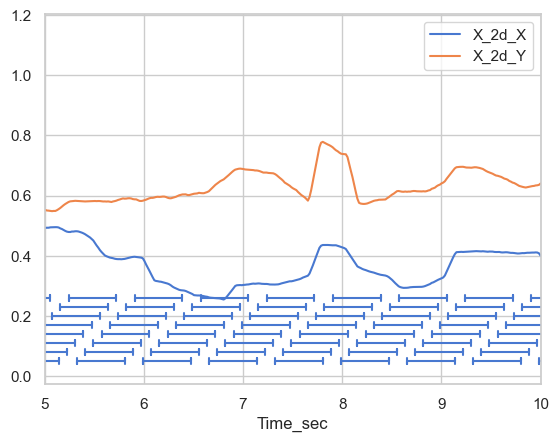

In [284]:
# plot example windows
# Calculate time range for each window
window_times = df_windows[df_windows["user_task"] == "Ishfaq_truss"].groupby('window_index')['Time_sec'].agg(['min', 'max']).reset_index()
ax = example_df.plot(x="Time_sec", y=["X_2d_X", "X_2d_Y"], xlim=(5, 10))

for i in range(200):
    height = 0.03*(i%8) + 0.05
    delta = 0.01
    window_range = window_times.iloc[i, [1,2]]
    window_line = plt.Line2D([window_range['min'], window_range['min'], window_range['min'], window_range['max'], window_range['max'], window_range['max']], 
                             [height + delta, height - delta, height, height, height + delta, height - delta])
    ax.add_line(window_line)

### Method 1
### Extracting manual features <a name="manual-feature-extraction"></a>

After anonymizing the data records we will do some manual feature engineering on our data in order to provide more meaningful features for our clustering algorithms. Based on previous literature we have decided to include the following features:

1. Eye metrics
   - Average pupil diameter (mm)
   - Average eye movement velocity (deg/s)
   - Average eye movement acceleration (deg/s/s)
   - Ratio of fixation/saccade (s)
   - Number of fixations
   - Average fixation duration (s)
   - Spatial variance of fixations (deg)
   - Mean saccade velocity (deg/s)
   - Mean saccade amplitude (deg)
1. Movement patterns (within 1s window)
   - Average movement velocity (m/s)
   - Average turning velocity (deg/s)
   - Total action, including translation and rotation

These features are selected to capture cognitive behavior patterns
while being meaningful within a 1-second analysis window

In [ ]:
def extract_features_from_window(window_df) -> pd.DataFrame:
    # collapse fixations and saccades into groups
    
    # calculate centroids of fixation / saccade groups
    
    
    return pd.Series({
        "average_pupil_diameter" : 1,
        "average_eye_movement_vel" : 2,
        "average_eye_movement_acc" : 2,
        "fixation_saccade_ratio" : 2,
        "number_of_fixations": 2,
        "average_fixation_duration": 2,
        "spatial_variance_fixations": 2,
        "mean_saccade_velocity": 2,
        "mean_saccade_amplitude": 2,
        "average_movement_velocity": 2,
        "average_turning_velocity": 2,
        "total_action": 2
    })

features_df = df_windows.groupby('window_index').apply(extract_features_from_window)
features_df

C:\Users\DANNY\AppData\Local\Temp\ipykernel_48104\1329005123.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  features_df = df_windows.groupby('window_index').apply(extract_features_from_window)


average  mean  idk
window_index                    
0                   1     2    2
1                   1     2    2
2                   1     2    2
3                   1     2    2
4                   1     2    2
...               ...   ...  ...
9343                1     2    2
9344                1     2    2
9345                1     2    2
9346                1     2    2
9347                1     2    2

[9348 rows x 3 columns]

### Trying different clustering techniques <a name="clustering1"></a>

In this section we will apply clustering techniques to the manual features created above. We will apply the following techniques and explore the clusters created.

1. PCA
2. T-SNE
3. K-means
4. Hierarchical clustering

In [7]:
'''# Load the data from the .pkl file
with open('manual_features_saved.pkl', 'rb') as file:
    data = pickle.load(file)

# Create a Pandas DataFrame from the loaded data
df = pd.DataFrame(data)

# Save the DataFrame to a .csv file
df.to_csv('manual_features_saved_2.csv', index=False)
raise SystemExit("Stopping here on purpose.")
#'''

'# Load the data from the .pkl file\nwith open(\'manual_features_saved.pkl\', \'rb\') as file:\n    data = pickle.load(file)\n\n# Create a Pandas DataFrame from the loaded data\ndf = pd.DataFrame(data)\n\n# Save the DataFrame to a .csv file\ndf.to_csv(\'manual_features_saved_2.csv\', index=False)\nraise SystemExit("Stopping here on purpose.")\n#'

Using features for clustering:
1.- avg_pupil_diameter
2.- avg_eye_velocity_degps
3.- avg_eye_accel_degps2
4.- avg_eye_velocity_lin
5.- avg_eye_accel_lin
6.- n_fixations
7.- avg_fixation_duration
8.- fixation_spatial_variance
9.- fix_sacc_ratio
10.- mean_saccade_velocity
11.- mean_saccade_amplitude
12.- gaze_area_covered
13.- head_area_covered
Scaled features shape: (4535, 13)

--- Performing PCA ---
Explained variance ratio (first 2 components): [0.35244606 0.21051832]
Cumulative explained variance: 0.5630


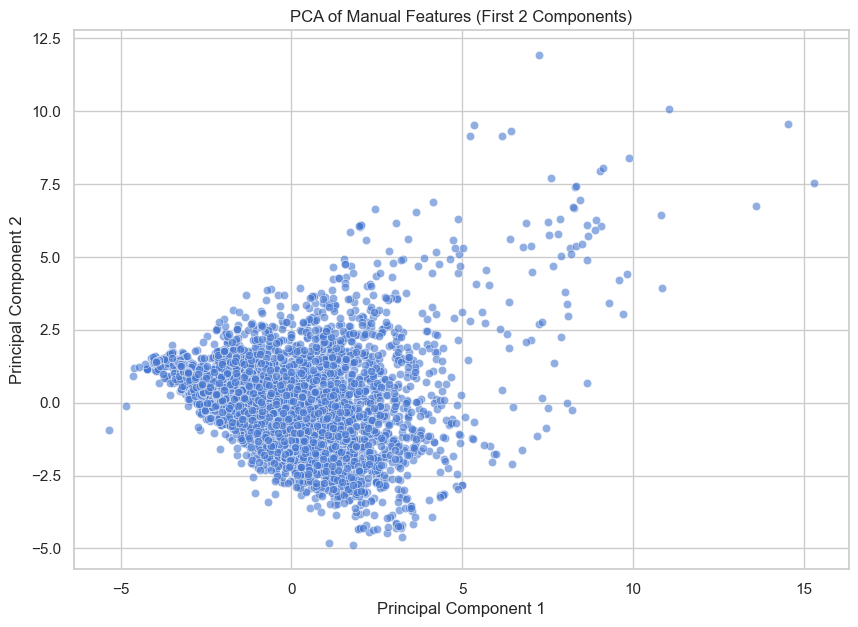

1 components → Cumulative explained variance: 35.24 %
2 components → Cumulative explained variance: 56.30 %
3 components → Cumulative explained variance: 71.78 %
4 components → Cumulative explained variance: 86.55 %
5 components → Cumulative explained variance: 93.40 %
6 components → Cumulative explained variance: 98.39 %

 Minimum components needed for 95% variance: 6

--- Performing T-SNE ---
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4535 samples in 0.005s...
[t-SNE] Computed neighbors for 4535 samples in 0.248s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4535
[t-SNE] Computed conditional probabilities for sample 2000 / 4535
[t-SNE] Computed conditional probabilities for sample 3000 / 4535
[t-SNE] Computed conditional probabilities for sample 4000 / 4535
[t-SNE] Computed conditional probabilities for sample 4535 / 4535
[t-SNE] Mean sigma: 0.427074
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.177879
[t-SNE] KL divergence af

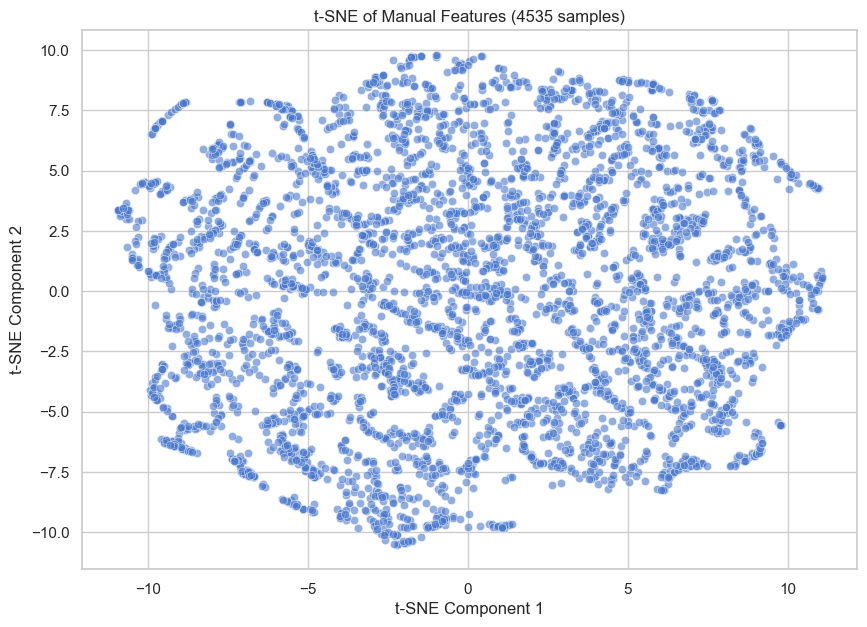


--- Performing K-Means Clustering ---


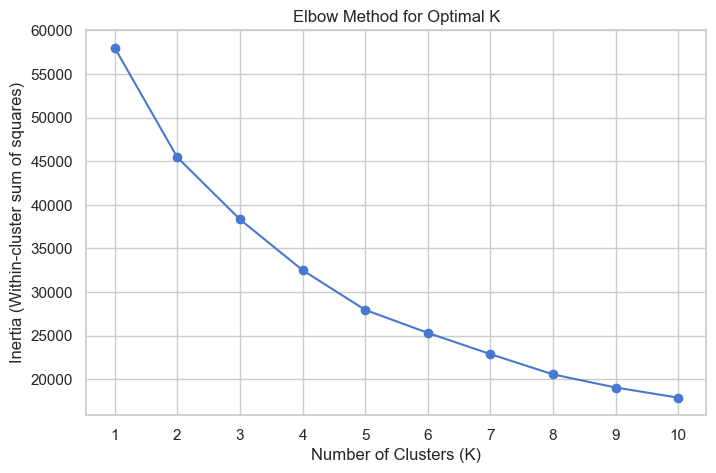

Selected K = 4

--- Interpreting KMeans Clusters ---


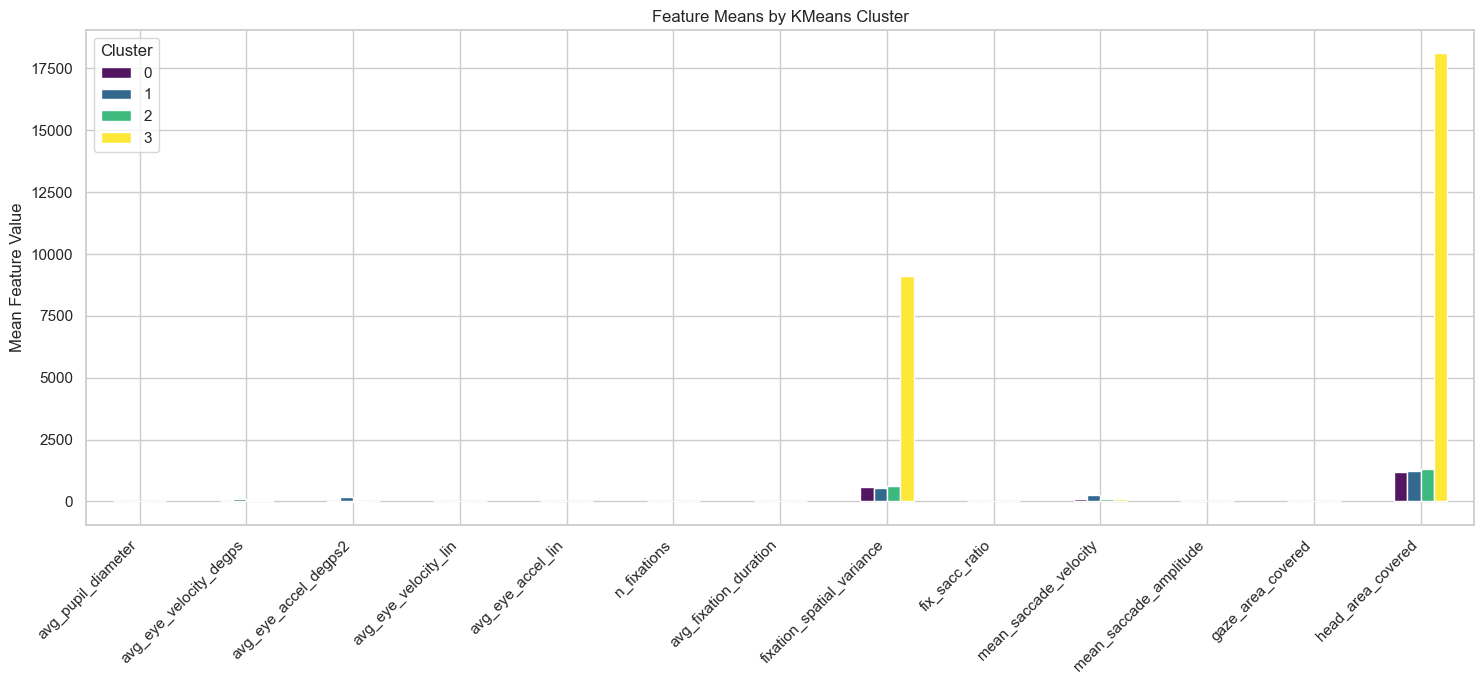

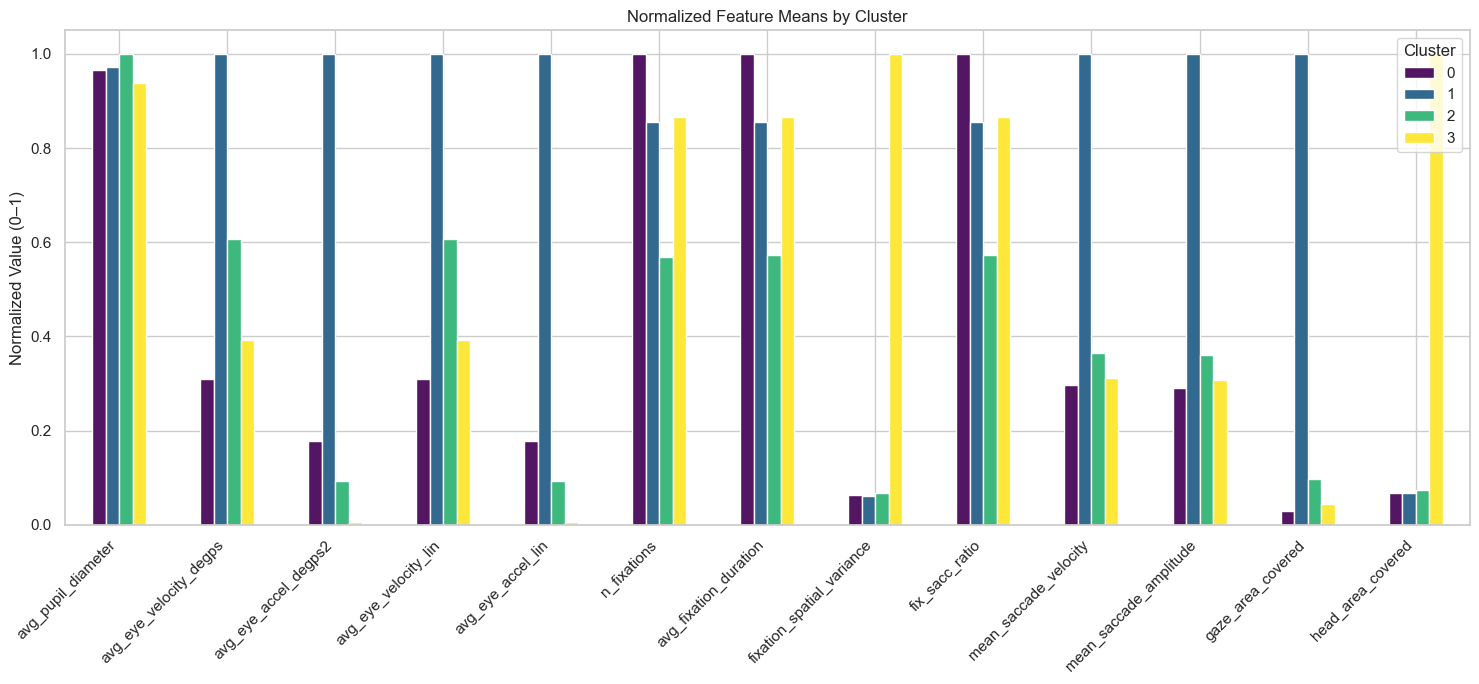

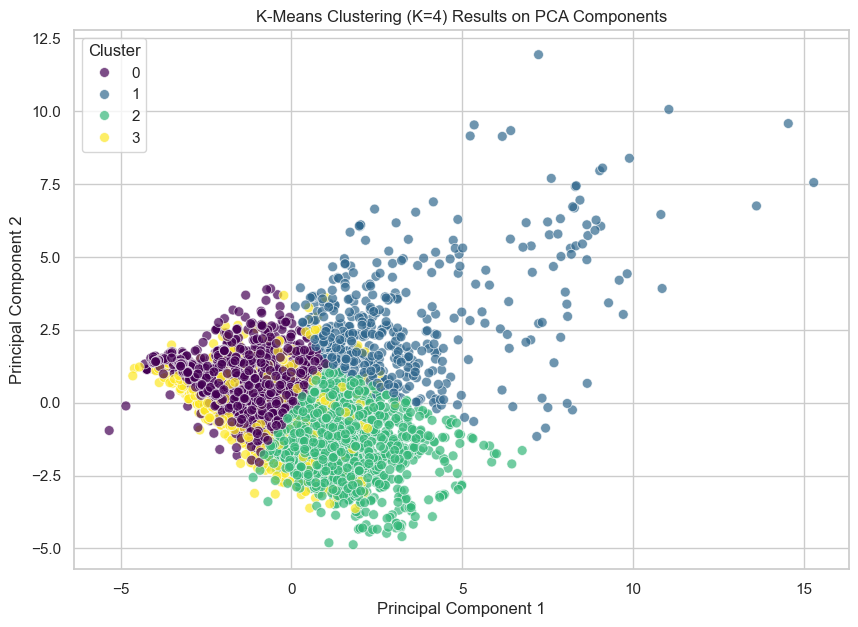


Silhouette Score: 0.2672
Davies-Bouldin Index: 1.2680
Calinski-Harabasz Index: 1184.47

--- Performing Hierarchical Clustering ---


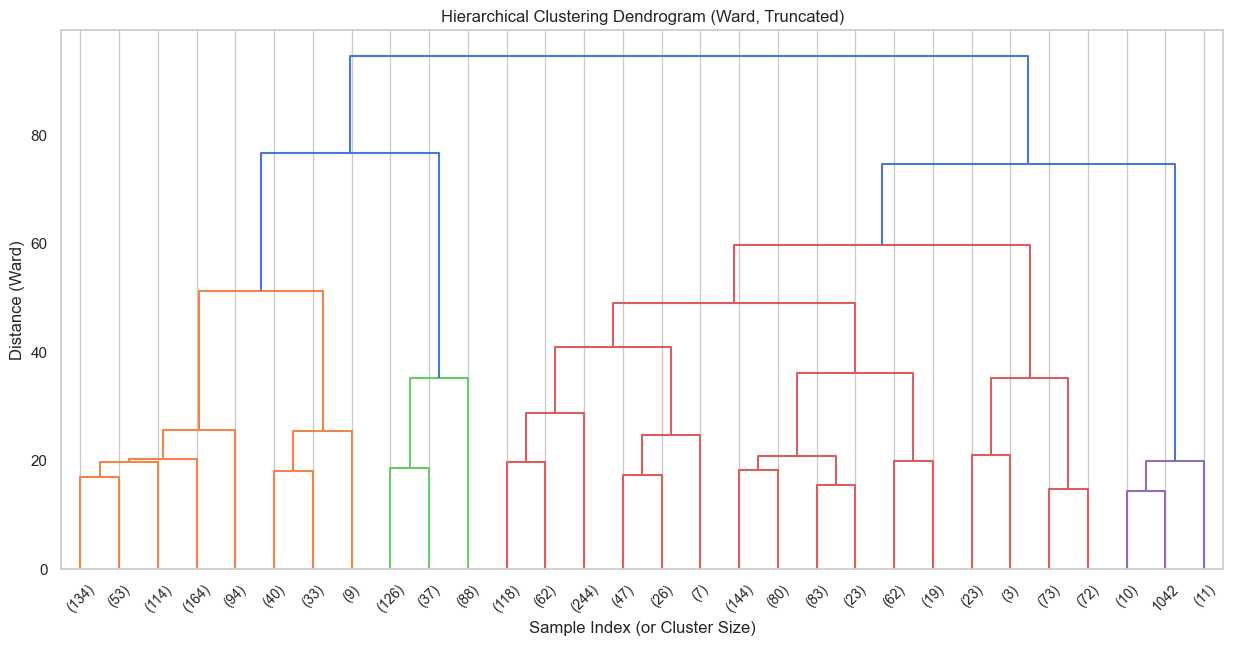

Selected number of hierarchical clusters = 4

Adjusted Rand Index (Aligned): 0.405


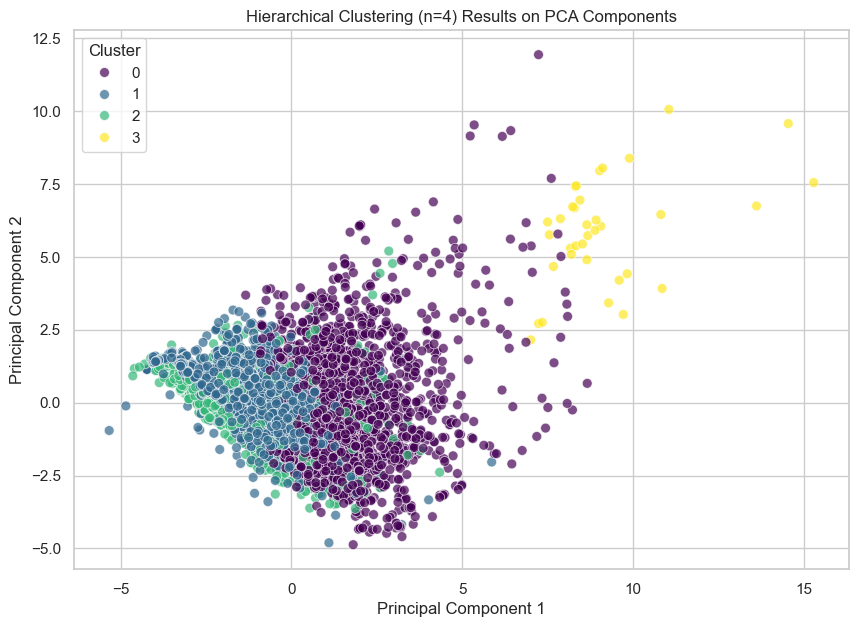


Silhouette Score: 0.2158
Davies-Bouldin Index: 1.3130
Calinski-Harabasz Index: 925.82


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score

# --- Seed setup for reproducibility (Optional) ---
# np.random.seed(33)

# --- Data Preparation ---
feature_columns = manual_features_df.select_dtypes(include=np.number).columns
cols_to_exclude = ['window_index', 'kmeans_cluster', 'hierarchical_cluster']
feature_columns = [col for col in feature_columns if col not in cols_to_exclude]
print("Using features for clustering:")
for i,feature in enumerate(feature_columns,start=1):
    print(f"{i}.- {feature}")

# Scale the features
features_for_clustering = manual_features_df[feature_columns].fillna(0).replace([np.inf, -np.inf], 0)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)
print(f"Scaled features shape: {scaled_features.shape}")


########## 1. PCA (Dimensionality Reduction & Visualization) ##########
print("\n--- Performing PCA ---")

# ---- PCA for 2 components just for visualization ----
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
print(f"Explained variance ratio (first 2 components): {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# ---- Plot PCA 2 components ----
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], alpha=0.6)
plt.title('PCA of Manual Features (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# ---- PCA for 90% variance, scaled features reduced ----
pca_full = PCA(n_components=scaled_features.shape[1])  # Fit PCA on full feature space
pca_full.fit(scaled_features)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
for i, cum_var in enumerate(cumulative_variance, start=1):
    print(f"{i} components → Cumulative explained variance: {cum_var*100:.2f} %")
    if cum_var >= 0.95:
        print(f"\n Minimum components needed for 95% variance: {i}")
        break
reduced_data = PCA(n_components=i).fit_transform(scaled_features)

# Select between reduced_data or scaled_features
features_processed_kmeans = reduced_data
features_processed_hierarchical = scaled_features

########## 2. T-SNE (Dimensionality Reduction & Visualization) ##########
print("\n--- Performing T-SNE ---")

# Note: T-SNE can be computationally expensive on large datasets.
# PCA if it's too slow.
n_samples_tsne = min(5000, features_processed_kmeans.shape[0]) # Limit samples for performance
indices = np.random.choice(features_processed_kmeans.shape[0], n_samples_tsne, replace=False)
scaled_features_subset = features_processed_kmeans[indices, :]
# pca_result_subset = pca_result[indices, :] # Can apply t-SNE on PCA results too
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=300, verbose=1)
tsne_result = tsne.fit_transform(scaled_features_subset) # Use subset for T-SNE

# ---- Plot ----
plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], alpha=0.6)
plt.title(f't-SNE of Manual Features ({n_samples_tsne} samples)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()


########## 3. K-Means Clustering ##########
print("\n--- Performing K-Means Clustering ---")

# ----- Optimal K using the Elbow method -----
inertia = []
k_range = range(1, 11) # Check K from 1 to 10
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # Suppress warning
    kmeans_test.fit(features_processed_kmeans)
    inertia.append(kmeans_test.inertia_)
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Choose K based on the elbow plot
optimal_k = 4
print(f"Selected K = {optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_processed_kmeans)
manual_features_df['kmeans_cluster'] = kmeans_labels

# --- Interpret KMeans Clusters Bar Plot ---
print("\n--- Interpreting KMeans Clusters ---")
cols_to_exclude = ['kmeans_cluster', 'hierarchical_cluster'] # Previous defined, not to compute
features_to_plot = [col for col in feature_columns if col not in cols_to_exclude]
cluster_summary = manual_features_df.groupby('kmeans_cluster')[features_to_plot].mean().T
custom_palette = {
    0: "#531662",   # purple
    1: "#33698e",   # blue
    2: "#3eb97e",   # green
    3: "#fde839"    # yellow
}
cluster_ids = cluster_summary.columns.tolist()
cluster_summary.plot(kind='bar', color=[custom_palette[i] for i in cluster_ids],figsize=(15, 7))
plt.title("Feature Means by KMeans Cluster")
plt.ylabel("Mean Feature Value")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.legend(title="Cluster", labels=[f"{i}" for i in cluster_ids])
plt.show()

# --- Interpret KMeans Clusters Normalized Bar Plot ----
rows_to_fix = ['avg_eye_accel_degps2', 'avg_eye_velocity_lin', 'avg_eye_accel_lin']
cluster_summary.loc[rows_to_fix] = cluster_summary.loc[rows_to_fix].abs()
cluster_summary_norm = cluster_summary.div(cluster_summary.max(axis=1), axis=0)
cluster_summary_norm.plot(kind='bar', color=[custom_palette[i] for i in cluster_ids],figsize=(15, 7))
plt.title("Normalized Feature Means by Cluster")
plt.ylabel("Normalized Value (0–1)")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.legend(title="Cluster", labels=[f"{i}" for i in cluster_ids])
plt.show()

# Visualize K-Means clusters using PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=kmeans_labels, palette='viridis', alpha=0.7, s=50)
plt.title(f'K-Means Clustering (K={optimal_k}) Results on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# --- Evaluate Clustering Quality ---
sil_score = silhouette_score(features_processed_kmeans, kmeans_labels) # Distance to closely clusters
db_score = davies_bouldin_score(features_processed_kmeans, kmeans_labels) # Separation of clusters
ch_score = calinski_harabasz_score(reduced_data, kmeans_labels)
inertia = kmeans.inertia_
print(f"\nSilhouette Score: {sil_score:.4f}") # Should be greater than 0.25 ideally
print(f"Davies-Bouldin Index: {db_score:.4f}")  # Should be less than 1.0 ideally
print(f"Calinski-Harabasz Index: {ch_score:.2f}")


########## 4. Hierarchical Clustering ##########
print("\n--- Performing Hierarchical Clustering ---")

# Generate the linkage matrix using Ward's method
# Use a subset if the dataset is very large, as linkage calculation can be heavy
n_samples_hc = min(2000, features_processed_hierarchical.shape[0])
indices_hc = np.random.choice(features_processed_hierarchical.shape[0], n_samples_hc, replace=False)
scaled_features_subset_hc = features_processed_hierarchical[indices_hc, :]
linked = linkage(scaled_features_subset_hc, method='ward')

# ----- Plot the dendrogram ----- 
plt.figure(figsize=(15, 7))
dendrogram(linked,
           orientation='top',
           # labels=manual_features_df.index[indices_hc].tolist(), # Optional: add labels if meaningful/small subset
           distance_sort='descending',
           show_leaf_counts=True,
           truncate_mode='lastp', # Show only the last p merged clusters
           p=30) # Adjust 'p' to control dendrogram complexity
plt.title('Hierarchical Clustering Dendrogram (Ward, Truncated)')
plt.xlabel('Sample Index (or Cluster Size)')
plt.ylabel('Distance (Ward)') 
plt.grid(axis='y')
plt.show()

# Choose the number of clusters based on the dendrogram (e.g., by cutting at a certain height)
num_hierarchical_clusters = 4
print(f"Selected number of hierarchical clusters = {num_hierarchical_clusters}")

# ----- Agglomerative Clustering -----
agg_cluster = AgglomerativeClustering(n_clusters=num_hierarchical_clusters, linkage='ward')
hierarchical_labels = agg_cluster.fit_predict(features_processed_hierarchical) # Fit on all data
manual_features_df['hierarchical_cluster'] = hierarchical_labels

# --- Compare KMeans vs Hierarchical ---
ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
print(f"\nAdjusted Rand Index (Aligned): {ari:.3f}")

# Visualize Hierarchical clusters using PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=hierarchical_labels, palette='viridis', alpha=0.7, s=50)
plt.title(f'Hierarchical Clustering (n={num_hierarchical_clusters}) Results on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# --- Evaluate Clustering Quality ---
sil_score = silhouette_score(features_processed_hierarchical, hierarchical_labels)
db_score = davies_bouldin_score(features_processed_hierarchical, hierarchical_labels)
ch_score = calinski_harabasz_score(reduced_data, hierarchical_labels)
print(f"\nSilhouette Score: {sil_score:.4f}") # Should be greater than 0.25 ideally
print(f"Davies-Bouldin Index: {db_score:.4f}") # Should be less than 1.0 ideally
print(f"Calinski-Harabasz Index: {ch_score:.2f}")

### Visualizing clusters <a name="visualize-clusters1"></a>

We will visualize the different clusters created from the algorithms and evaluate whether these clusters correspond to specific cognitive patterns, or any other patterns observed between the different clusters.

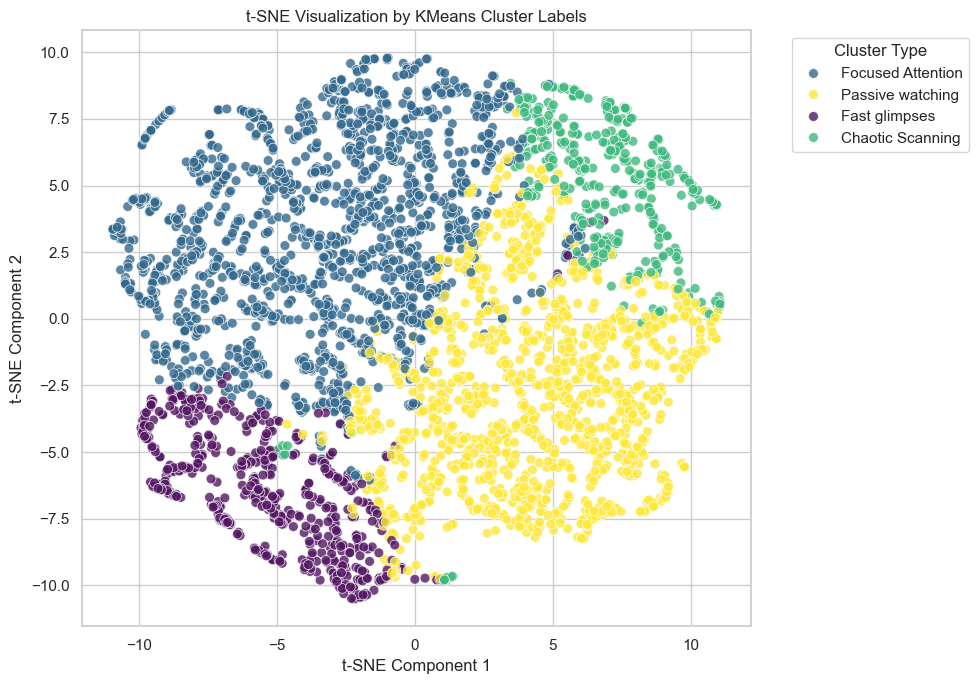

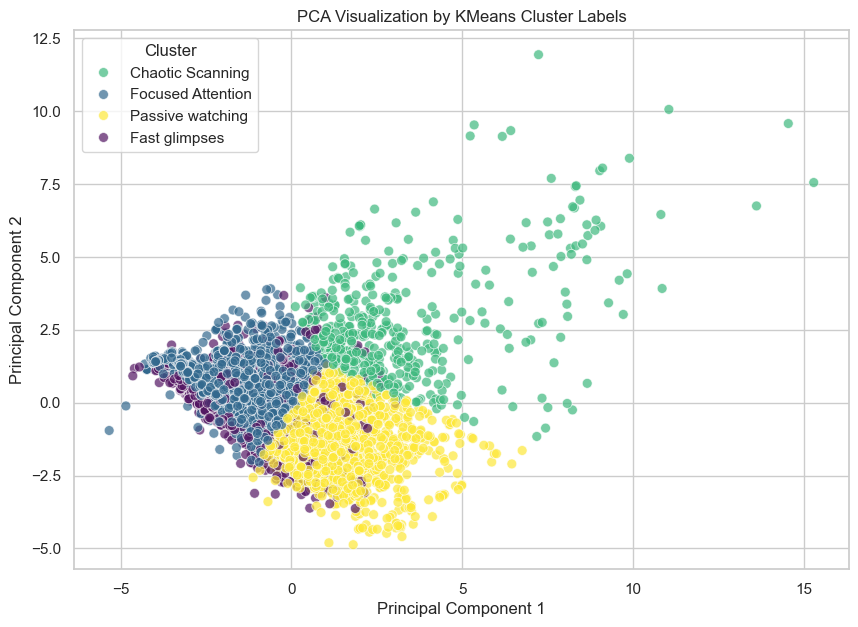

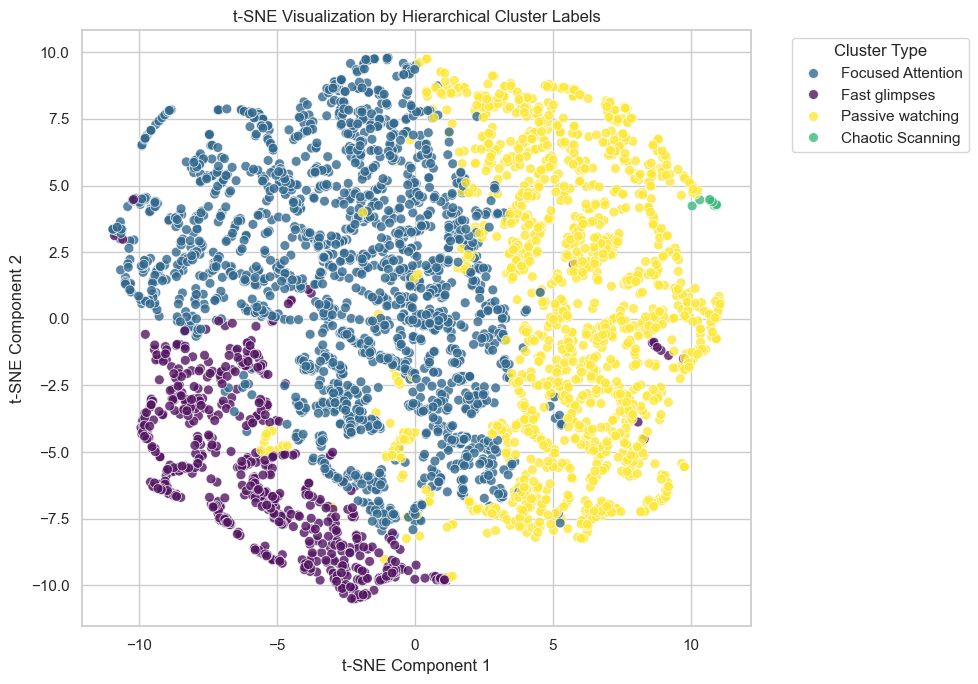

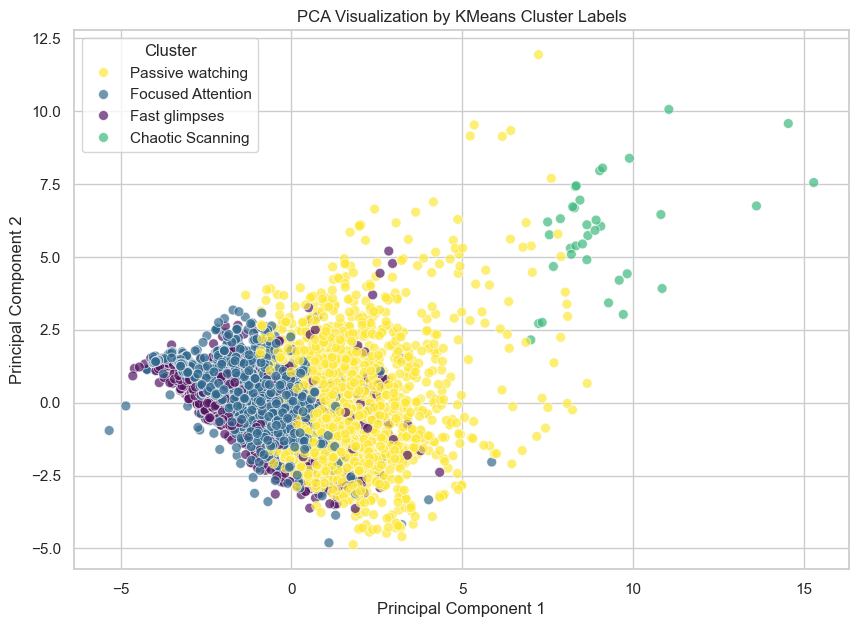

In [9]:
# Define color palette for descriptive labels
custom_label_palette = {
    "Focused Attention": "#33698e",         # blue
    "Chaotic Scanning": "#3eb97e",          # green
    "Passive watching": "#fde839",          # yellow
    "Fast glimpses": "#531662"              # purple
}

############ K-MEANS ############
# Compute features summary per cluster
summary_kmeans = manual_features_df.groupby('kmeans_cluster').mean(numeric_only=True)
# Identify which cluster has highest gaze_area_covered (likely "Chaotic Scanning")
chaotic_cluster = summary_kmeans['avg_eye_velocity_lin'].idxmax()
focused_cluster = summary_kmeans['avg_eye_velocity_lin'].idxmin()
passive_cluster = summary_kmeans['avg_fixation_duration'].idxmin()
glimpse_cluster = summary_kmeans['fixation_spatial_variance'].idxmax()

# Map accordingly
cluster_labels_kmeans = {
    chaotic_cluster: "Chaotic Scanning",
    focused_cluster: "Focused Attention",
    passive_cluster: "Passive watching", # Exploratory view, Surveying, Casual Observation, Review
    glimpse_cluster: "Fast glimpses", # Quick scanning, overlook behavior
}

# Assign human-readable cluster labels
manual_features_df['kmeans_cluster_label'] = manual_features_df['kmeans_cluster'].map(cluster_labels_kmeans)

# Prepare t-SNE dataframe with labels
tsne_colored = manual_features_df.iloc[indices].copy()
tsne_colored['tsne_x'] = tsne_result[:, 0]
tsne_colored['tsne_y'] = tsne_result[:, 1]
tsne_colored['kmeans_label'] = tsne_colored['kmeans_cluster_label']  # human-readable

# Plot using the correct palette that matches string labels
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_colored,x='tsne_x',y='tsne_y',hue='kmeans_label',palette=custom_label_palette,s=50,alpha=0.8)
plt.title('t-SNE Visualization by KMeans Cluster Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize K-Means clusters using PCA results
pca_colored = manual_features_df.copy()
pca_colored['pca_x'] = pca_result[:, 0]
pca_colored['pca_y'] = pca_result[:, 1]
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_colored, x='pca_x', y='pca_y', hue='kmeans_cluster_label', palette=custom_label_palette, alpha=0.7, s=50)
plt.title(f'PCA Visualization by KMeans Cluster Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


############ HIERARCHICAL ###############
# Compute features summary per cluster
summary_hierarchical = manual_features_df.groupby('hierarchical_cluster').mean(numeric_only=True)
# Identify which cluster has highest gaze_area_covered (likely "Chaotic Scanning")
chaotic_cluster = summary_hierarchical['avg_eye_velocity_lin'].idxmax()
focused_cluster = summary_hierarchical['avg_eye_velocity_lin'].idxmin()
passive_cluster = summary_hierarchical['avg_fixation_duration'].idxmin()
glimpse_cluster = summary_hierarchical['fixation_spatial_variance'].idxmax()

# Map accordingly
cluster_labels_hierarchical = {
    chaotic_cluster: "Chaotic Scanning",
    focused_cluster: "Focused Attention",
    passive_cluster: "Passive watching",
    glimpse_cluster: "Fast glimpses",
}

manual_features_df['hierarchical_cluster_label'] = manual_features_df['hierarchical_cluster'].map(cluster_labels_hierarchical)

# Prepare t-SNE dataframe with labels
tsne_colored = manual_features_df.iloc[indices].copy()
tsne_colored['tsne_x'] = tsne_result[:, 0]
tsne_colored['tsne_y'] = tsne_result[:, 1]
tsne_colored['hierarchical_label'] = tsne_colored['hierarchical_cluster_label']  # human-readable

# Plot using the correct palette that matches string labels
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_colored,x='tsne_x',y='tsne_y',hue='hierarchical_label',palette=custom_label_palette,s=50,alpha=0.8)
plt.title('t-SNE Visualization by Hierarchical Cluster Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize Hierarchical clusters using PCA results
pca_colored = manual_features_df.copy()
pca_colored['pca_x'] = pca_result[:, 0]
pca_colored['pca_y'] = pca_result[:, 1]
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_colored, x='pca_x', y='pca_y', hue='hierarchical_cluster_label', palette=custom_label_palette, alpha=0.7, s=50)
plt.title(f'PCA Visualization by KMeans Cluster Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## Method 2

### Deep feature extraction and Clustering <a name="deep-feature-extraction"></a>

In this section we will use unsupervised deep learning approaches like Autoencoders, Variational Autoencoders (VAE), and LSTM Autoencoders to extract latent features from the raw data or the manually selected features.

### Deep Autoencoder

The first method we will use is the deep autoencoder. This is a dimensionality reduction technique which uses a fully-connected neural network to reduce the size of the input vector and then reconstruct it from the reduced version. The idea is that the model will be forced to ignore faulty information such as noise in order to minimize the reconstruction loss. We define all of our pytorch models in the models.py file, including the deep autoencoder model.

Using device: cpu
Shape of x_flat: torch.Size([4, 13])
Shape of x_seq: torch.Size([4, 8, 13])

--- DeepAE ---
Output shape: torch.Size([4, 13])

--- VAE ---
Output shape: torch.Size([4, 13])
Mu shape: torch.Size([4, 4])
LogVar shape: torch.Size([4, 4])

--- LSTM_AE ---
Output shape: torch.Size([4, 8, 13])


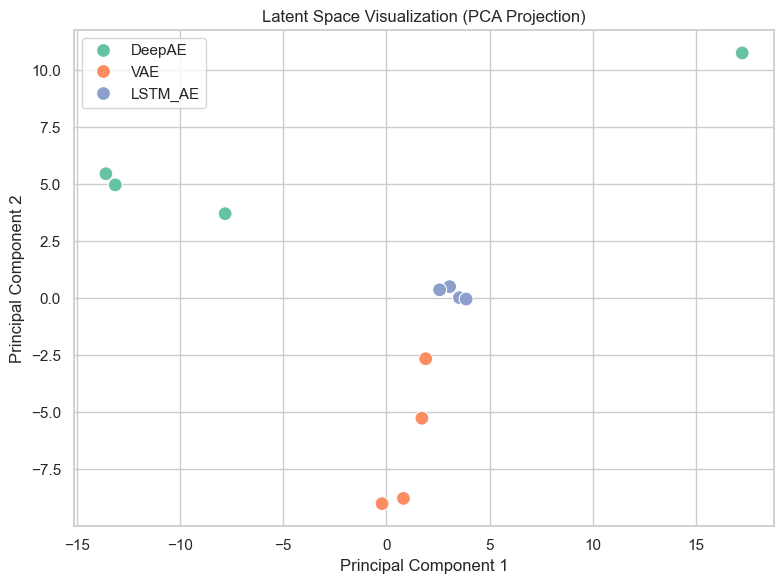

In [ ]:
import models
import torch
import torch.nn.functional as F
import numpy as np

# --- 1. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. Common settings ---
input_dim = x_flat_np.shape[1]
encoding_dim = 4
hidden_dims = [15, 10, 5]
seq_len = 8
batch_size = 4

# --- 3. Preprocessed manual features ---
# Flatten the feature dataframe to match the expected input shape of DeepAE and VAE
# Exclude non-numeric columns and handle missing values
feature_columns = manual_features_df.select_dtypes(include=np.number).columns
cols_to_exclude = ['window_index', 'kmeans_cluster', 'hierarchical_cluster']
feature_columns = [col for col in feature_columns if col not in cols_to_exclude]
features_for_clustering = manual_features_df[feature_columns].fillna(0).replace([np.inf, -np.inf], 0)
x_flat_np = features_for_clustering.values.astype(np.float32)  # Convert to numpy array

# Convert numpy array to PyTorch tensor and move to the device
x_flat = torch.from_numpy(x_flat_np[:batch_size]).to(device)

# For LSTM_AE, reshape the data into sequences
# Here, we'll use a simple approach of taking 'seq_len' consecutive windows as a sequence
x_seq_np = []
for i in range(batch_size):
    start_idx = i * seq_len
    end_idx = start_idx + seq_len
    if end_idx <= len(x_flat_np):
        x_seq_np.append(x_flat_np[start_idx:end_idx])
    else:
        # Pad with zeros if there are not enough windows for a full sequence
        padding_size = end_idx - len(x_flat_np)
        padded_sequence = np.concatenate([x_flat_np[start_idx:], np.zeros((padding_size, x_flat_np.shape[1]))], axis=0)
        x_seq_np.append(padded_sequence)

x_seq_np = np.array(x_seq_np)
x_seq = torch.from_numpy(x_seq_np).to(device)

print("Shape of x_flat:", x_flat.shape)
print("Shape of x_seq:", x_seq.shape)

# --- 4. Deep Autoencoder ---
print("\n--- DeepAE ---")
deepae = models.DeepAE(input_dim=input_dim, encoding_dim=encoding_dim, hidden_dims=hidden_dims).to(device)
out_deepae = deepae(x_flat)
print("Output shape:", out_deepae.shape)

# --- 5. Variational Autoencoder ---
print("\n--- VAE ---")
vae = models.VAE(input_dim=input_dim, latent_dim=encoding_dim, hidden_dims=hidden_dims).to(device)
out_vae, mu, log_var = vae(x_flat)
print("Output shape:", out_vae.shape)
print("Mu shape:", mu.shape)
print("LogVar shape:", log_var.shape)

# --- 6. LSTM Autoencoder ---
print("\n--- LSTM_AE ---")
lstm_ae = models.LSTM_AE(input_dim=input_dim, seq_len=seq_len, hidden_dim=16, latent_dim=encoding_dim).to(device)
out_lstm = lstm_ae(x_seq)
print("Output shape:", out_lstm.shape)


### Exploring deep feature clusters

We will again use algorithms such as PCA, t-SNE, k-means and hierarchical clustering to cluster the deep features and visualize the latent space. As done before we will evaluate whether these clusters correspond to specific patterns in the inspections.

## Testing generality of clusters

To test the generality of these cluster we will load the warehouse data. For this dataset the user was asked to find a specific graffiti inside a warehouse full of graffiti. Although the task is very different in nature, the cognitive patterns should be similar, for example the clusters should be capable of identifying when the person is looking at a graffiti and deciding if it is the correct one or not. On the other hand, we might find that the clusters generated don't generalize well to this problem.